In [4]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
# Set the theme of graph (style), color (palette), font scale 
sns.set(style='darkgrid', palette='muted', font_scale=1.5)
# figure size in inches
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]



In [5]:
df = pd.read_csv('data/creditcard.csv')

In [6]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
print(df.shape)
print(df.describe())

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271

In [8]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

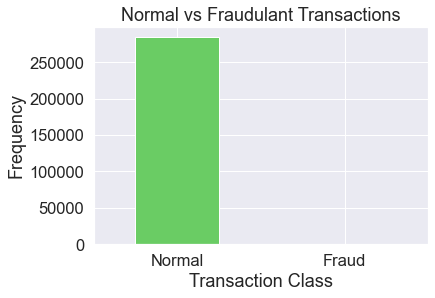

In [9]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency")



In [10]:
fraudsDF = df[df.Class == 1]
normalDF = df[df.Class == 0]

In [11]:
fraudsDF.shape

(492, 31)

In [12]:
normalDF.shape

(284315, 31)

In [13]:
fraudsDF.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
normalDF.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Create two histograms to show number of transactions to a group of amount ranging from 0 to 20000

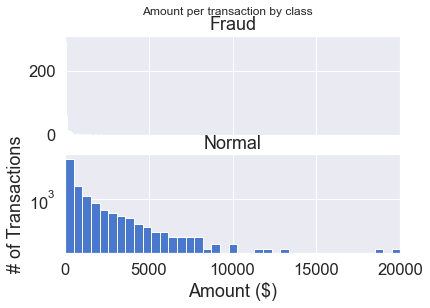

In [15]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudsDF.Amount, bins=bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.Amount, bins=bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('# of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

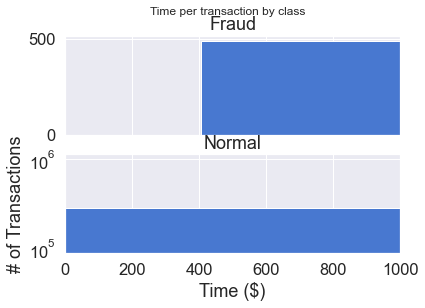

In [16]:

f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Time per transaction by class')

bins = 1

ax1.hist(fraudsDF.Time, bins=bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.Time, bins=bins)
ax2.set_title('Normal')

plt.xlabel('Time ($)')
plt.ylabel('# of Transactions')
plt.xlim((0, 1000))
plt.yscale('log')
plt.show()

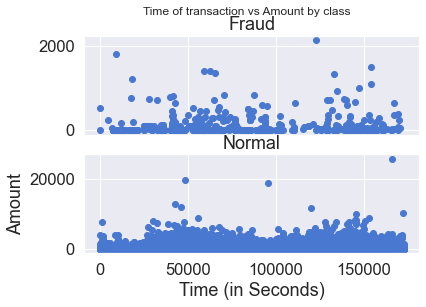

In [17]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Time, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Time, normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [18]:
transactionData = df.drop(['Time'], axis=1)
print(transactionData)

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V21       V22  \
0       0.239599  0.098698  0.363787  0.090794  ... -0.01830

class StandardScaler(_OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
"""Standardize features by removing the mean and scaling to unit variance.
The standard score of a sample `x` is calculated as:

        z = (x - u) / s
where `u` is the mean of the training samples or zero if `with_mean=False`,
    and `s` is the standard deviation of the training samples or one if
    `with_std=False`.
Why? Covariance vs correlation.

Standardization of a dataset is a common requirement for many machine learning estimators



In [46]:
transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1, 1))
print(transactionData['Amount'].describe())

count    2.848070e+05
mean    -8.781773e-18
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount, dtype: float64
